In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(torch.__version__)

SEED=41

np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

1.0.0


### Template for a layer

In [2]:
class Layer:
    def __init__(self):
        pass
    
    def forward(self, input_):
        pass
    
    def backward(self, input_, grad_output):
        pass

In [3]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input_):
        output = torch.max(input_, torch.tensor([0.], device='cuda'))
        return output

In [78]:
class LogSoftmax(Layer):
    def __init__(self):
        pass
    
    def forward(self, input_):
        return F.log_softmax(input_, dim=1)
    
class Identity(Layer):
    def __init__(self):
        pass
    
    def forward(self, x):
        return x

In [53]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = torch.randn(input_units, output_units, device='cuda')*0.01
        self.biases  = torch.ones(output_units, device='cuda')
        
    def forward(self, input_):    
        self.layer_output = torch.matmul(input_, self.weights) + self.biases
        return self.layer_output
    
    def forward_with_params(self, x, weights, biases):
        return torch.matmul(x, weights) + biases
    
    def update(self, w_grad, b_grad):
        self.weights = self.weights - self.learning_rate * w_grad
        self.biases  = self.biases  - self.learning_rate * b_grad

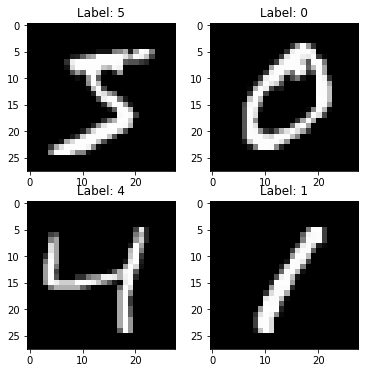

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32, device='cuda')
X_val   = torch.tensor(X_val, dtype=torch.float32, device='cuda')
X_test  = torch.tensor(X_test, dtype=torch.float32, device='cuda')

In [8]:
def forward(network, X):
    """
    Network is a list of layers
    X: Raw Feature Matrix
    
    Run Forward pass on the features to produce
    activations for every layer
    """
    activations = []
    input_      = X
    
    for layer in network:
        input_ = layer.forward(input_)
        activations.append(input_)
        
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    logits = forward(network, X)[-1]
    return logits.cpu().detach().numpy().argmax(axis=-1)

def normalize(vec, c):
    norm = torch.norm(vec)
    
    if norm >= c:
        return (c * vec) / norm
    else:
        return vec

### LRA-diff

#### Batch Creation

In [9]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

#### Network Definition

In [79]:
network  = []

# layer 1
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())

# layer 2
network.append(Dense(100, 200))
network.append(ReLU())

# layer 3
network.append(Dense(200, 10))
network.append(Identity())

#### Run on a single batch

In [125]:
def train(network, X, y):
    # parameters
    beta = .1
    
    c1   = .1
    c2   = .1
    K    = 1
    
    # forward pass to get all the activations from the network.
    layer_outputs = forward(network, X)

    # every layer is composed of affine layer followed by a activation function
    # so that is why we are taking every other value
    
    # pre-activations
    h_l         = [X] + layer_outputs[::2]
    
    # target for these pre-activations
    y_l_h       = h_l.copy()
    
    # create a temporary copy for these pre-activations
    h_l_hat     = h_l.copy()
    
    
    # post-activations
    z_l         = [X] + layer_outputs[1::2]
    
    # target for post-activations
    y_l_z       = z_l.copy()
    
    # create a temporary copy for these post-activationss
    z_l_hat     = z_l.copy()
    
    # add the true target to the list
    y_l_z[-1]   = torch.tensor(y, dtype=torch.long, device='cuda')

    
    # calculate number of layers in the network
    n_layers    = len(network) // 2
    
    # layer index ( start at the final layer )
    l           = len(network)
    
    # start at the final layer
    layer       = n_layers
    
    # list to store grads
    W_grads     = []
    b_grads     = []
    
    # losses
    mse_loss = nn.MSELoss()
#     nll_loss = nn.NLLLoss()
    nll_loss = nn.CrossEntropyLoss()
    
    print('Before backward pass')
    print('Layer 0th targets: ', y_l_z[0][0][:4])
    print('Layer 1st targets: ', y_l_z[1][0][:4])
    print('Layer 2nd targets: ', y_l_z[2][0][:4])
    print('Layer 3rd targets: ', y_l_z[3])
    print()
    print('*' * 100)
    
    while layer > 0:
        
        # lth layer weights and biases
        W_l = torch.autograd.Variable(network[l-2].weights, requires_grad=True)        
        b_l = torch.autograd.Variable(network[l-2].biases, requires_grad=True)
        
        # previous layer input 
        h_prev = h_l[layer - 1] # can't do it when layer == 1, 
                                # because it is not defined
        z_prev = network[l-3].forward(h_prev)
        
        # current input
        layer_pre_act  = network[l-2].forward_with_params(z_prev, W_l, b_l)
        layer_post_act = network[l-1].forward(layer_pre_act)
            
        # layer set target
        layer_target   = y_l_z[layer]
        
        
        if layer != n_layers:
            loss = mse_loss(layer_post_act, layer_target)
        else:
            loss = nll_loss(layer_post_act, layer_target)
        
        # backward pass
        loss.backward()
        
        # weight and bias gradients
        W_l_grad = normalize(W_l.grad.data, c1)
        b_l_grad = normalize(b_l.grad.data, c1)
        
        # add weight and bias grads to the list
        W_grads.append(W_l_grad)
        b_grads.append(b_l_grad)
        
        # turn off requires grad flag for both biases and weights
        W_l.requires_grad = False
        b_l.requires_grad = False
        
        # create a new temporary variable for new scope inside the loop
        h_l_hat_tmp = h_l_hat[layer - 1]
        
        
        for k in range(K):
            h_l_hat_tmp    = torch.autograd.Variable(h_l_hat_tmp, 
                                                     requires_grad=True)
            
            z_l_hat_tmp    = network[l-3].forward(h_l_hat_tmp)
            layer_pre_act  = network[l-2].forward_with_params(z_l_hat_tmp, 
                                                              W_l, 
                                                              b_l)
            
            layer_post_act = network[l-1].forward(layer_pre_act)
            
            
            if layer != n_layers:
                loss = mse_loss(layer_post_act, layer_target)
            else:
                loss = nll_loss(layer_post_act, layer_target)
            
            loss.backward()
            
            if layer == 2:
                print('Layer post activations: {}'.format(layer_post_act[0][:5]))
                print('Layer target: {}'.format(layer_target[0][:5]))
                print('Loss incurred: {}'.format(loss))
                print('H prev grad: {}'.format(torch.norm(h_l_hat_tmp.grad.data)))
            
            # store derivative of layer loss w.r.t prev layer's input
            h_prev_grad      = normalize(h_l_hat_tmp.grad.data, 
                                         c2)
            
            h_l_hat_tmp      = h_prev - beta * h_prev_grad
            z_l_hat[layer-1] = network[l-3].forward(h_l_hat_tmp)
            
            if layer == 3:
                print('Current loss incurred: {}'.format(loss))
                print('Current h prev grad: {}'.format(torch.norm(h_prev_grad,p=2)))
                print('target for prev layer ( 2 )', z_l_hat[layer-1][0][:5])
                print('h prev ', h_prev[0][:4])
                print('after ', h_l_hat_tmp[0][:4])
            
            h_l_hat[layer]   = torch.matmul(z_l_hat[layer-1], W_l) + b_l
            z_l_hat[layer]   = network[l-1].forward(h_l_hat[layer])
        
        y_l_z[layer-1] = z_l_hat[layer-1]
                
        # unit in a layer index
        l     -= 2

        # update the layer index
        layer -= 1
    
    W_grads = W_grads[::-1]
    b_grads = b_grads[::-1]
    
    return W_grads, b_grads

In [126]:
network  = []

# layer 1
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())

# layer 2
network.append(Dense(100, 200))
network.append(ReLU())

# layer 3
network.append(Dense(200, 10))
network.append(Identity())

### Run on a single minibatch ( optional )

In [127]:
xtr, ytr       = next(iterate_minibatches(X_train, 
                                          y_train, 
                                          batchsize=2, 
                                          shuffle=True))
W_grad, b_grad = train(network, xtr, ytr)

# print(torch.norm(W_grad[0], p=2))
# print('*' * 100)
# print(torch.norm(W_grad[1], p=2))
# print('*' * 100)
# print(torch.norm(W_grad[2], p=2))
# print('*' * 100)

  0%|          | 0/25000 [00:00<?, ?it/s]

Before backward pass
Layer 0th targets:  tensor([0., 0., 0., 0.], device='cuda:0')
Layer 1st targets:  tensor([0.9079, 1.0721, 1.0404, 1.0960], device='cuda:0')
Layer 2nd targets:  tensor([0.9944, 0.9408, 1.0212, 1.0755], device='cuda:0')
Layer 3rd targets:  tensor([9, 4], device='cuda:0')

****************************************************************************************************
Current loss incurred: 2.3011250495910645
Current h prev grad: 0.0975695550441742
target for prev layer ( 2 ) tensor([0.9947, 0.9408, 1.0223, 1.0739, 0.8519], device='cuda:0')
h prev  tensor([0.9944, 0.9408, 1.0212, 1.0755], device='cuda:0')
after  tensor([0.9947, 0.9408, 1.0223, 1.0739], device='cuda:0')
Layer post activations: tensor([0.9944, 0.9408, 1.0212, 1.0755, 0.8517], device='cuda:0',
       grad_fn=<SliceBackward>)
Layer target: tensor([0.9947, 0.9408, 1.0223, 1.0739, 0.8519], device='cuda:0')
Loss incurred: 2.3799499615506647e-07
H prev grad: 4.70350414616405e-06


### Full Training

Epoch 2
Train accuracy: 0.09976
Val accuracy: 0.0961


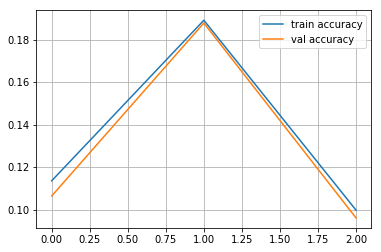

In [124]:
from IPython.display import clear_output

train_log = []
val_log   = []

for epoch in range(3):
    batch_count = 0
        
    for x_batch, y_batch in iterate_minibatches(X_train, 
                                                y_train, 
                                                batchsize=32, 
                                                shuffle=True):        

        W_grads, b_grads = train(network, x_batch, y_batch)
        layer            = 0


        for l in range(0, len(network), 2):
            network[l].update(W_grads[layer], b_grads[layer])
            layer += 1

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()